In [1]:
import sys

sys.path.insert(0, '3DDFA')

import torch
import random
import torchvision.transforms as transforms
import numpy as np
import cv2
import dlib
import scipy.io as sio
import pandas as pd

import argparse
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# init 3DDFA

In [42]:
# import json

# end_dataset = [1, 2, 4]
# with open('preprocessed_dataset/dataset.json', 'w') as outfile:
#     json.dump(end_dataset, outfile)

In [2]:
torch.cuda.is_available()

True

In [3]:
dlib_landmark_model = '3DDFA/models/shape_predictor_68_face_landmarks.dat'
face_regressor = dlib.shape_predictor(dlib_landmark_model)
face_detector = dlib.get_frontal_face_detector()


In [4]:
ffhq_model = 'ffhq-dataset-v2.json'

train_data = pd.read_json(ffhq_model, orient='column')

In [41]:
index = random.randrange(70000)
# index = 18198
image = train_data[index]['image']['file_path']
keypoints = train_data[index]['image']['face_landmarks']
output_size = 240
print(image, train_data[index])

images1024x1024/48000/48774.png category                                                training
metadata       {'photo_url': 'https://www.flickr.com/photos/3...
image          {'file_url': 'https://drive.google.com/uc?id=1...
thumbnail      {'file_url': 'https://drive.google.com/uc?id=1...
in_the_wild    {'file_url': 'https://drive.google.com/uc?id=1...
Name: 48774, dtype: object


rectangles[[(233, 357) (788, 911)]]


Text(0.5, 1.0, 'dlib prediction')

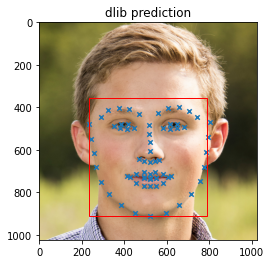

In [42]:
img = cv2.imread(image)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = face_detector(RGB_img, 1)
print(rects)
if len(rects) == 0:
    print("skip image %s, could not find landmarks" % (image))

rects = sorted(rects, key=lambda x: x.width() * x.height(), reverse=True)
rect = rects[0]
fig, axis = plt.subplots()
axis.imshow(RGB_img)
corner = [rect.tl_corner().x, rect.tl_corner().y]
axis.add_patch(patches.Rectangle(corner, rect.width(), rect.height(), linewidth=1, edgecolor='r', facecolor='none'))

pts = face_regressor(RGB_img, rect).parts()
pts = np.array([[pt.x, pt.y] for pt in pts]).T
axis.scatter(pts[0], pts[1], marker='x', s=20)
plt.title('dlib prediction')


In [43]:
def findPointsBounds(points, offset):
    bot_left_x = min(point for point in points[0])
    bot_left_y = min(point for point in points[1])
    top_right_x = max(point for point in points[0])
    top_right_y = max(point for point in points[1])

    return [[int(bot_left_x - offset), int(bot_left_y - offset)], [int(top_right_x + offset), int(top_right_y + offset)]]
    

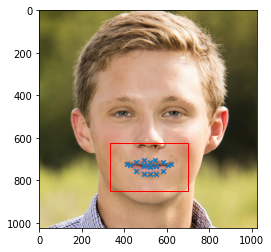

In [44]:
fig, axis = plt.subplots()
axis.scatter(pts[0][48::], pts[1][48::], marker='x', s=20)
[a, b] = findPointsBounds([pts[0][48::], pts[1][48::]], 80)
axis.imshow(RGB_img)
axis.add_patch(patches.Rectangle((a), b[0] - a[0], b[1] - a[1], linewidth=1, edgecolor='r', facecolor='none'))

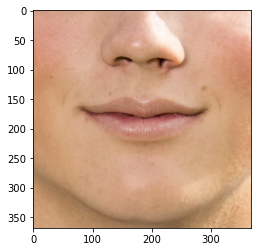

In [45]:
fig, axis = plt.subplots()

middleX = (b[0] - a[0]) / 2 + a[0]
middleY = (b[1] - a[1]) / 2 + a[1]

resHalf = max(output_size / 2, max(b[1] - a[1], b[0] - a[0])) / 2

cornerA = [
    middleX - resHalf,
    middleY - resHalf
]

cornerB = [
    middleX + resHalf,
    middleY + resHalf
]

imgCropped = RGB_img[int(cornerA[1]):int(cornerB[1]), int(cornerA[0]):int(cornerB[0])]
axis.imshow(imgCropped)

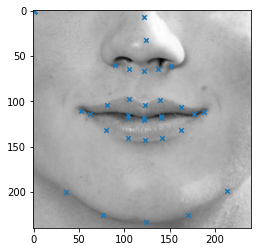

In [46]:
fig, axis = plt.subplots()

offseted_keypoints = []
scale = output_size / (resHalf * 2)
for index in range(0, 68):
    point = [pts[0][index] - cornerA[0], pts[1][index] - cornerA[1]]
    if point[0] < 0 or point[0] >= resHalf * 2 or point[1] < 0 or point[1] >= resHalf * 2:
        point = [0, 0]
    point = np.array(point) * scale
    offseted_keypoints.append(point)
offseted_keypoints = np.array(offseted_keypoints).flatten()

graysacale = cv2.cvtColor(imgCropped, cv2.COLOR_RGB2GRAY)
graysacale = cv2.resize(graysacale, dsize=(output_size, output_size))
axis.imshow(graysacale, cmap="gray")

axis.scatter(offseted_keypoints[0::2], offseted_keypoints[1::2], marker='x', s=20)